In [1]:
# Author: Kaylani Bochie
# github.com/kaylani2
# kaylani AT gta DOT ufrj DOT br

### K: Model: MLP
import sys
import time
import pandas as pd
import os
import math
sys.path.insert(1, './')
import numpy as np
from numpy import mean, std
from matplotlib import pyplot as plt
from unit import remove_columns_with_one_value, remove_nan_columns, load_dataset
from unit import display_general_information, display_feature_distribution
from collections import Counter
#from imblearn.over_sampling import RandomOverSampler, RandomUnderSampler
import sklearn
from sklearn import set_config
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, PredefinedSplit, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import keras.utils
from keras import metrics
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM
from keras.optimizers import RMSprop, Adam
from keras.constraints import maxnorm
import susi
from susi.SOMPlots import plot_umatrix, plot_estimation_map


###############################################################################
## Define constants
###############################################################################

CICIDS_DIRECTORY = '../../../datasets/MachineLearningCVE/'
CICIDS_MONDAY_FILENAME = 'Monday-WorkingHours.pcap_ISCX.csv'
CICIDS_WEDNESDAY_FILENAME = 'Wednesday-workingHours.pcap_ISCX.csv'
CICIDS_MONDAY = CICIDS_DIRECTORY + CICIDS_MONDAY_FILENAME
CICIDS_WEDNESDAY = CICIDS_DIRECTORY + CICIDS_WEDNESDAY_FILENAME

In [19]:
'''
pd.set_option ('display.max_rows', None)
pd.set_option ('display.max_columns', 5)
BOT_IOT_DIRECTORY = '../../../../../datasets/bot-iot/'
BOT_IOT_FEATURE_NAMES = 'UNSW_2018_IoT_Botnet_Dataset_Feature_Names.csv'
BOT_IOT_FILE_5_PERCENT_SCHEMA = 'UNSW_2018_IoT_Botnet_Full5pc_{}.csv' # 1 - 4
FIVE_PERCENT_FILES = 4
BOT_IOT_FILE_FULL_SCHEMA = 'UNSW_2018_IoT_Botnet_Dataset_{}.csv' # 1 - 74
FULL_FILES = 74
FILE_NAME = BOT_IOT_DIRECTORY + BOT_IOT_FILE_5_PERCENT_SCHEMA
FEATURES = BOT_IOT_DIRECTORY + BOT_IOT_FEATURE_NAMES
NAN_VALUES = ['?', '.']
TARGET = 'attack'
INDEX_COLUMN = 'pkSeqID'
LABELS = ['attack', 'category', 'subcategory']
STATE = 0
try:
  STATE = int (sys.argv [1])
except:
  pass
#for STATE in [1, 2, 3, 4, 5]:
np.random.seed (STATE)
print ('STATE:', STATE)
'''

###############################################################################
## Load dataset
###############################################################################
#df = load_dataset (FILE_NAME, FIVE_PERCENT_FILES, INDEX_COLUMN, NAN_VALUES)
df = pd.read_csv (CICIDS_WEDNESDAY)

## Fraction dataframe for quicker testing (copying code is hard)
#df = df.sample (frac = 0.1, replace = True, random_state = 0)
#print ('Using fractured dataframe.')

In [ ]:
###############################################################################
## Quick sanity check
###############################################################################
display_general_information (df)

In [20]:
## Remove NaN and inf values
df.replace ('Infinity', np.nan, inplace = True) ## Or other text values
df.replace (np.inf, np.nan, inplace = True) ## Remove infinity
df.replace (np.nan, 0, inplace = True)
## We can also use scikit-learn to use other strategies for substitution
print ('Dataframe contains NaN values:', df.isnull ().values.any ())
nanColumns = [i for i in df.columns if df [i].isnull ().any ()]
print ('NaN columns:', nanColumns)

###############################################################################
## Encode categorical attributes (this may be done before finding pearson)
###############################################################################
print ('Label types before conversion:', df [' Label'].unique ())
df [' Label'] = df [' Label'].replace ('BENIGN', 0)
df [' Label'] = df [' Label'].replace ('DoS slowloris', 1)
df [' Label'] = df [' Label'].replace ('DoS Slowhttptest', 1)
df [' Label'] = df [' Label'].replace ('DoS Hulk', 1)
df [' Label'] = df [' Label'].replace ('DoS GoldenEye', 1)
df [' Label'] = df [' Label'].replace ('Heartbleed', 1)
print ('Label types after conversion:', df [' Label'].unique ())
df.info (verbose = False)

Dataframe contains NaN values: False
NaN columns: []
Label types before conversion: ['BENIGN' 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']
Label types after conversion: [0 1]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692703 entries, 0 to 692702
Columns: 79 entries,  Destination Port to  Label
dtypes: float64(24), int64(55)
memory usage: 417.5 MB


In [21]:
###############################################################################
## Clean dataset
###############################################################################
###############################################################################
### Remove columns with only one value
df, log = remove_columns_with_one_value (df, verbose = False)
print (log)

While removing single value columns: (10, 'column (s) dropped.')


In [5]:
###############################################################################
### Remove redundant columns, useless columns and unused targets
### K: _number columns are numerical representations of other existing columns.
### K: category and subcategory are other labels.
### K: saddr and daddr may specialize the model to a single network
'''
redundant_columns = ['state_number', 'proto_number', 'flgs_number']
other_targets = ['category', 'subcategory']
misc_columns = ['saddr', 'daddr']
print ('Removing redundant columns:', redundant_columns)
print ('Removing useless targets:', other_targets)
print ('Removing misc columns:', misc_columns)
columns_to_remove = redundant_columns + other_targets + misc_columns
df.drop (axis = 'columns', columns = columns_to_remove, inplace = True)
'''
###############################################################################
### Remove NaN columns (with a lot of NaN values)
df, log = remove_nan_columns (df, 1/2, verbose = False)
print (log)

While removing nan value columns: No columns dropped.


In [22]:
###############################################################################
### Encode categorical features
print ('Encoding categorical features (ordinal encoding).')
my_encoder = OrdinalEncoder ()
'''
df ['flgs'] = my_encoder.fit_transform (df ['flgs'].values.reshape (-1, 1))
df ['proto'] = my_encoder.fit_transform (df ['proto'].values.reshape (-1, 1))
df ['sport'] = my_encoder.fit_transform (df ['sport'].astype (str).values.reshape (-1, 1))
df ['dport'] = my_encoder.fit_transform (df ['dport'].astype (str).values.reshape (-1, 1))
df ['state'] = my_encoder.fit_transform (df ['state'].values.reshape (-1, 1))
'''
df [' Label'] = my_encoder.fit_transform (df [' Label'].values.reshape (-1, 1))
print ('Objects:', list (df.select_dtypes ( ['object']).columns))


###############################################################################
## Quick sanity check
###############################################################################
display_general_information (df)

Encoding categorical features (ordinal encoding).
Objects: []
Dataframe shape (lines, columns): (692703, 69) 

First 5 entries:
     Destination Port   Flow Duration   Total Fwd Packets  \
0                 80           38308                   1   
1                389             479                  11   
2                 88            1095                  10   
3                389           15206                  17   
4                 88            1092                   9   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        1                            6   
1                        5                          172   
2                        6                         3150   
3                       12                         3452   
4                        6                         3150   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             6                       6   
1                           326      

Fwd Packets/s                                382443  
 Bwd Packets/s                               358777  
 Min Packet Length                              166  
 Max Packet Length                             4469  
 Packet Length Mean                           61803  
 Packet Length Std                           135696  
 Packet Length Variance                      133816  
FIN Flag Count                                    2  
 SYN Flag Count                                   2  
 RST Flag Count                                   2  
 PSH Flag Count                                   2  
 ACK Flag Count                                   2  
 URG Flag Count                                   2  
 ECE Flag Count                                   2  
 Down/Up Ratio                                   17  
 Average Packet Size                          60919  
 Avg Fwd Segment Size                         31471  
 Avg Bwd Segment Size                         41095  
 Fwd Header Length.1        

In [23]:
###############################################################################
## Split dataset into train and test sets
###############################################################################
### K: Dataset is too big? Drop.
# drop_indices = np.random.choice (df.index, int (df.shape [0] * 0.5),
#                                  replace = False)
# df = df.drop (drop_indices)
TARGET = ' Label'
STATE = 0
TEST_SIZE = 3/10
VALIDATION_SIZE = 1/4
print ('Splitting dataset (test/train):', TEST_SIZE)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split (
                                               df.loc [:, df.columns != TARGET],
                                               df [TARGET],
                                               test_size = TEST_SIZE,
                                               random_state = STATE,)
print ('Splitting dataset (validation/train):', VALIDATION_SIZE)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split (
                                             X_train_df,
                                             y_train_df,
                                             test_size = VALIDATION_SIZE,
                                             random_state = STATE,)
print ('X_train_df shape:', X_train_df.shape)
print ('y_train_df shape:', y_train_df.shape)
print ('X_val_df shape:', X_val_df.shape)
print ('y_val_df shape:', y_val_df.shape)
print ('X_test_df shape:', X_test_df.shape)
print ('y_test_df shape:', y_test_df.shape)

Splitting dataset (test/train): 0.3
Splitting dataset (validation/train): 0.25
X_train_df shape: (363669, 68)
y_train_df shape: (363669,)
X_val_df shape: (121223, 68)
y_val_df shape: (121223,)
X_test_df shape: (207811, 68)
y_test_df shape: (207811,)


In [24]:
###############################################################################
## Convert dataframe to a numpy array
###############################################################################
print ('\nConverting dataframe to numpy array.')
X_train = X_train_df.values
y_train = y_train_df.values
X_val = X_val_df.values
y_val = y_val_df.values
X_test = X_test_df.values
y_test = y_test_df.values
print ('X_train shape:', X_train.shape)
print ('y_train shape:', y_train.shape)
print ('X_val shape:', X_val.shape)
print ('y_val shape:', y_val.shape)
print ('X_test shape:', X_test.shape)
print ('y_test shape:', y_test.shape)


Converting dataframe to numpy array.
X_train shape: (363669, 68)
y_train shape: (363669,)
X_val shape: (121223, 68)
y_val shape: (121223,)
X_test shape: (207811, 68)
y_test shape: (207811,)


In [ ]:
# for column in df.columns:
#    hist = df [column].hist(bins=3)
#    print (column)
#    plt.scatter(df [column], df ['attack'], s=100,)# c=df.female
#    plt.show ()


### PLOT
print (type (X_train))
#print (((X_train_df.dtypes)))
#print (df ['spkts'].values)

#hist = df.hist (column = 'mean', figsize = (12, 8))

### K: .count () takes a bit too long...
#df.groupby ('mean').count ().plot ()


from matplotlib.ticker import StrMethodFormatter

for column in df.columns:
    
    print (column)
    ax = df.hist(column=column,# bins = np.logspace(np.log10(0.1),np.log10(1.0), 50),
                 bins = 40,
                 #bins = max (df [column].nunique (), 50),
                 grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
    ax = ax[0]
    for x in ax:
        # Despine
#         x.spines['right'].set_visible(False)
#         x.spines['top'].set_visible(False)
#         x.spines['left'].set_visible(False)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="on", top="on", labelbottom="on", left="on", right="on", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("")

        # Set x-axis label
        x.set_xlabel(column, labelpad=20, weight='bold', size=22)

        # Set y-axis label
        x.set_ylabel('# de amostras', labelpad=20, weight='bold', size=22)
        
        #x.set_xticklabels(x_ticks, rotation=0, fontsize=20)
        plt.rc('xtick',labelsize=20)
        plt.rc('ytick',labelsize=20)

        #x.set_xticklabels(x_ticks, rotation=0, fontsize=20)


        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
        x.figure.savefig (column + '.png')
        x.plot ()
        


#plt.scatter(df ['bytes'], df ['attack'], s=100,)# c=df.female
#plt.show ()
#plt.scatter ()

In [ ]:
### Print pearson
import seaborn as sb
pearsoncorr = df.corr(method='pearson')
print (pearsoncorr)

def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    #ax.set_xticks([x_to_num[v] for v in x_labels])
    #ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    #ax.set_yticks([y_to_num[v] for v in y_labels])
    #ax.set_yticklabels(y_labels)

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sb_plot = sb.heatmap(pearsoncorr, 
            #xticklabels=pearsoncorr.columns,
            #yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            #annot=True,
            linewidth=0.5)
sb_plot.figure.savefig("output.png")

In [25]:
###############################################################################
## Apply normalization
###############################################################################
### K: NOTE: Only use derived information from the train set to avoid leakage.
print ('\nApplying normalization.')
startTime = time.time ()
scaler = StandardScaler ()
#scaler = MinMaxScaler (feature_range = (0, 1))
scaler.fit (X_train)
X_train = scaler.transform (X_train)
X_val = scaler.transform (X_val)
X_test = scaler.transform (X_test)
print (str (time.time () - startTime), 'to normalize data.')


Applying normalization.
0.8738613128662109 to normalize data.


In [26]:
###############################################################################
## Perform feature selection
###############################################################################
NUMBER_OF_FEATURES = 30 #X_train.shape [-1]
print ('\nSelecting top', NUMBER_OF_FEATURES, 'features.')
fs = PCA (n_components = NUMBER_OF_FEATURES)
fs.fit (X_train)
print (fs.explained_variance_ratio_)
print (fs.singular_values_)
X_train = fs.transform (X_train)
X_val = fs.transform (X_val)
X_test = fs.transform (X_test)
print ('X_train shape:', X_train.shape)
print ('y_train shape:', y_train.shape)
print ('X_val shape:', X_val.shape)
print ('y_val shape:', y_val.shape)
print ('X_test shape:', X_test.shape)
print ('y_test shape:', y_test.shape)


Selecting top 30 features.
[0.26152853 0.16548568 0.06703872 0.06422403 0.04968429 0.04694743
 0.03626722 0.0314246  0.029107   0.02755981 0.0265944  0.02123074
 0.01909486 0.01660971 0.01522837 0.01442534 0.01325025 0.01219125
 0.01205345 0.01029892 0.00890498 0.00800287 0.00718169 0.00615059
 0.00567567 0.0046504  0.00420488 0.00374863 0.00294392 0.00210314]
[2543.12165819 2022.96240694 1287.56886766 1260.24901564 1108.45267874
 1077.49060727  947.03214894  881.54086752  848.41102392  825.55439361
  810.96612943  724.58636116  687.17253697  640.89754384  613.66923274
  597.26996004  572.42633072  549.07509787  545.96304709  504.66518179
  469.27137935  444.86740671  421.42568662  390.00126154  374.6417595
  339.1195182   322.46636439  304.46957129  269.81763525  228.05610573]
X_train shape: (363669, 30)
y_train shape: (363669,)
X_val shape: (121223, 30)
y_val shape: (121223,)
X_test shape: (207811, 30)
y_test shape: (207811,)


In [32]:

###############################################################################
## Create learning model (MLP)
###############################################################################
from keras.models import Sequential
from keras.layers import Dense, Dropout
BATCH_SIZE = 128
NUMBER_OF_EPOCHS = 100
LEARNING_RATE = 0.0001
numberOfClasses = len (df [' Label'].unique ())
model = Sequential ()
model.add (Dense (units = 512, activation = 'relu',
                  input_shape = (X_train.shape [1], )))
model.add (Dense (256, activation = 'relu'))
model.add (Dense (128, activation = 'relu'))
model.add (Dense (numberOfClasses - 1, activation = 'sigmoid'))
print ('Model summary:')
model.summary ()

###############################################################################
## Compile the network
###############################################################################
from keras.optimizers import RMSprop
from keras.optimizers import Adam
model.compile (loss = 'binary_crossentropy',
               optimizer = Adam (lr = LEARNING_RATE),
               metrics = ['accuracy'])

Model summary:
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               15872     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 180,225
Trainable params: 180,225
Non-trainable params: 0
_________________________________________________________________


In [33]:
###############################################################################
## Fit the network
###############################################################################
history = model.fit (X_train, y_train,
                     batch_size = BATCH_SIZE,
                     epochs = NUMBER_OF_EPOCHS,
                     verbose = 1,
                     validation_split = 1/10)

Epoch 1/100
2558/2558 [==============================] - 8s 3ms/step - loss: 0.1004 - accuracy: 0.9676 - val_loss: 0.0345 - val_accuracy: 0.9892
Epoch 2/100
2558/2558 [==============================] - 8s 3ms/step - loss: 0.0290 - accuracy: 0.9899 - val_loss: 0.0286 - val_accuracy: 0.9907
Epoch 3/100
2558/2558 [==============================] - 15s 6ms/step - loss: 0.0251 - accuracy: 0.9911 - val_loss: 0.0255 - val_accuracy: 0.9913
Epoch 4/100
2558/2558 [==============================] - 14s 6ms/step - loss: 0.0233 - accuracy: 0.9913 - val_loss: 0.0240 - val_accuracy: 0.9919
Epoch 5/100
2558/2558 [==============================] - 18s 7ms/step - loss: 0.0219 - accuracy: 0.9921 - val_loss: 0.0287 - val_accuracy: 0.9906
Epoch 6/100
2558/2558 [==============================] - 14s 6ms/step - loss: 0.0211 - accuracy: 0.9924 - val_loss: 0.0260 - val_accuracy: 0.9917
Epoch 7/100
2558/2558 [==============================] - 20s 8ms/step - loss: 0.0197 - accuracy: 0.9930 - val_loss: 0.0217 - v

2558/2558 [==============================] - 9s 4ms/step - loss: 0.0102 - accuracy: 0.9970 - val_loss: 0.0326 - val_accuracy: 0.9963
Epoch 58/100
2558/2558 [==============================] - 9s 4ms/step - loss: 0.0109 - accuracy: 0.9968 - val_loss: 0.0366 - val_accuracy: 0.9949
Epoch 59/100
2558/2558 [==============================] - 9s 4ms/step - loss: 0.0108 - accuracy: 0.9968 - val_loss: 0.0319 - val_accuracy: 0.9969
Epoch 60/100
2558/2558 [==============================] - 9s 4ms/step - loss: 0.0098 - accuracy: 0.9972 - val_loss: 0.0338 - val_accuracy: 0.9971
Epoch 61/100
2558/2558 [==============================] - 9s 4ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0334 - val_accuracy: 0.9967
Epoch 62/100
2558/2558 [==============================] - 9s 4ms/step - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0.0347 - val_accuracy: 0.9965
Epoch 63/100
2558/2558 [==============================] - 9s 4ms/step - loss: 0.0104 - accuracy: 0.9969 - val_loss: 0.0331 - val_accuracy

In [34]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

y_pred_keras = model.predict (X_test).ravel ()

print (y_test.shape)
print (y_pred_keras.shape)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

(207811,)
(207811,)


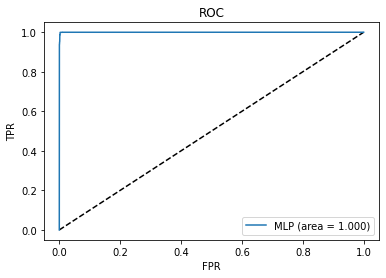

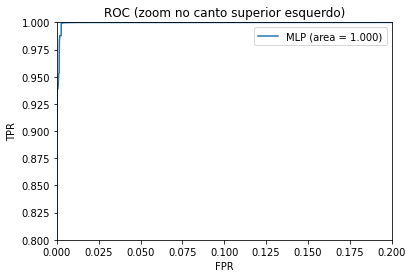

In [35]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='MLP (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc='best')
plt.savefig ('roc.png')
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='MLP (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC (zoom no canto superior esquerdo)')
plt.legend(loc='best')
plt.savefig ('roc_zoom.png')

plt.show()


Test loss: 0.018283497542142868
Test accuracy: 0.9972186088562012


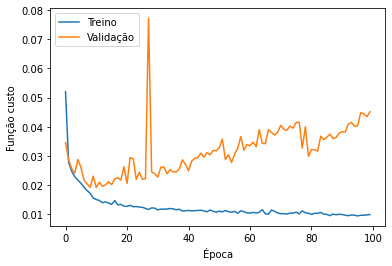

In [36]:
###############################################################################
## Analyze results
###############################################################################
scoreArray = model.evaluate (X_test, y_test, verbose = 0)
print ('Test loss:', scoreArray [0])
print ('Test accuracy:', scoreArray [1])

import matplotlib.pyplot as plt
plt.plot (history.history ['loss'])
plt.plot (history.history ['val_loss'])
plt.title ('')
plt.ylabel ('Função custo')
plt.xlabel ('Época')
plt.legend (['Treino', 'Validação'], loc = 'upper left')
plt.savefig ('loss.png')

In [37]:
###############################################################################
## Analyze results
###############################################################################
print ('\nPerformance on TRAIN set:')
y_pred = model.predict (X_train)
y_pred = y_pred.round ()
my_confusion_matrix = confusion_matrix (y_train, y_pred,
                                        labels = df [TARGET].unique ())
tn, fp, fn, tp = my_confusion_matrix.ravel ()
print ('Confusion matrix:')
print (my_confusion_matrix)
print ('Accuracy:', accuracy_score (y_train, y_pred))
print ('Precision:', precision_score (y_train, y_pred, average = 'macro'))
print ('Recall:', recall_score (y_train, y_pred, average = 'macro'))
print ('F1:', f1_score (y_train, y_pred, average = 'macro'))
print ('Cohen Kappa:', cohen_kappa_score (y_train, y_pred,
                       labels = df [TARGET].unique ()))
print ('TP:', tp)
print ('TN:', tn)
print ('FP:', fp)
print ('FN:', fn)
#sys.exit ()

### K: Only before publishing... Don't peek.
print ('\nPerformance on TEST set:')
y_pred = model.predict (X_test)
y_pred = y_pred.round ()
my_confusion_matrix = confusion_matrix (y_test, y_pred,
                                        labels = df [TARGET].unique ())
tn, fp, fn, tp = my_confusion_matrix.ravel ()
print ('Confusion matrix:')
print (my_confusion_matrix)
print ('Accuracy:', accuracy_score (y_test, y_pred))
print ('Precision:', precision_score (y_test, y_pred, average = 'macro'))
print ('Recall:', recall_score (y_test, y_pred, average = 'macro'))
print ('F1:', f1_score (y_test, y_pred, average = 'macro'))
print ('Cohen Kappa:', cohen_kappa_score (y_test, y_pred,
                       labels = df [TARGET].unique ()))
print ('TP:', tp)
print ('TN:', tn)
print ('FP:', fp)
print ('FN:', fn)



Performance on TRAIN set:
Confusion matrix:
[[230326    878]
 [    47 132418]]
Accuracy: 0.9974564782810743
Precision: 0.996604569359899
Recall: 0.9979238385707583
F1: 0.9972577148891981
Cohen Kappa: 0.994515460653384
TP: 132418
TN: 230326
FP: 878
FN: 47

Performance on TEST set:
Confusion matrix:
[[131579    551]
 [    27  75654]]
Accuracy: 0.9972186265404622
Precision: 0.9962821727469393
Recall: 0.9977365519568656
F1: 0.997001464390932
Cohen Kappa: 0.994002969888472
TP: 75654
TN: 131579
FP: 551
FN: 27
